# Test

In [1]:
# Import libraries
import os
import yaml
import torch
import numpy as np
import pandas as pd
from tueplots import bundles
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from mlres.modules.networks import WaveNet
from mlres.dataset import GermanWeatherEnergy

In [3]:
# Set the plotting parameters
plt.rcParams.update(bundles.neurips2024())

## Plot losses

In [4]:
# Create the output directory
outdir = 'plot_results'
os.makedirs(outdir, exist_ok=True)

In [5]:
# Get the losses
train_losses = dict()
val_losses = dict()
res_dir = '../cluster_results'
for name in os.listdir(res_dir):
    train_losses[name] = []
    val_losses[name] = []
    for seed in os.listdir(os.path.join(res_dir, name)):
        train_losses[name].append(np.load(os.path.join(res_dir, name, seed, 'train_losses.npy')))
        val_losses[name].append(np.load(os.path.join(res_dir, name, seed, 'val_losses.npy')))

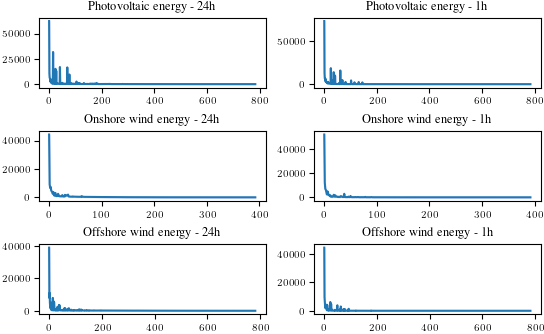

In [6]:
# Plot training losses
fig, axs = plt.subplots(3, 2)
it = 0
titles = {'photovoltaic': 'Photovoltaic energy - 24h', 
          'wind_onshore': 'Onshore wind energy - 24h',
          'wind_offshore': 'Offshore wind energy - 24h', 
          'photovoltaic_short': 'Photovoltaic energy - 1h', 
          'wind_onshore_short': 'Onshore wind energy - 1h',
          'wind_offshore_short': 'Offshore wind energy - 1h'
         }
for k in titles.keys():
    v = train_losses[k]
    x, y = np.arange(len(v[0])), np.mean(v, axis=0)
    ci = 1.96 * np.std(y)/np.sqrt(len(x))
    current_ax = axs[it % 3][int(it / 3)]
    current_ax.set_title(titles[k])
    current_ax.plot(x, y)
    current_ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
    it += 1

plt.savefig(os.path.join(outdir, "training_losses.svg"))
plt.show()

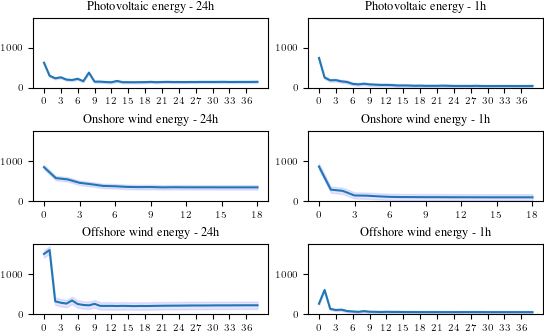

In [62]:
# Plot validation losses
fig, axs = plt.subplots(3, 2)
it = 0
titles = {'photovoltaic': 'Photovoltaic energy - 24h', 
          'wind_onshore': 'Onshore wind energy - 24h',
          'wind_offshore': 'Offshore wind energy - 24h', 
          'photovoltaic_short': 'Photovoltaic energy - 1h', 
          'wind_onshore_short': 'Onshore wind energy - 1h',
          'wind_offshore_short': 'Offshore wind energy - 1h'
         }
for k in titles.keys():
    v = val_losses[k]
    x, y = np.arange(len(v[0])), np.mean(v, axis=0)
    ci = 1.96 * np.std(y)/np.sqrt(len(x))
    current_ax = axs[it % 3][int(it / 3)]
    current_ax.set_ylim(0, 1750)
    current_ax.set_xticks(range(0, len(x), 3))
    current_ax.set_title(titles[k])
    current_ax.plot(x, y)
    current_ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
    it += 1

plt.savefig(os.path.join(outdir, "validation_losses.svg"))
plt.show()

## Compute RMSE

In [30]:
# Define auxillary methods
def load_cfg(path):
    with open(path, 'r') as file:
        try:
            cfg = yaml.safe_load(file)
        except yaml.YAMLError as exc:
            print(exc)
    return cfg

def run_test(model, test_loader):
    model.eval()
    RMSE = lambda x, y: torch.sqrt(torch.nn.MSELoss()(x, y))
    criterion = torch.nn.L1Loss()
    total_test_loss, total_rmse = 0, 0
    for i, (x, y) in enumerate(test_loader):
        with torch.no_grad():
            y_hat = model(torch.transpose(x, 2, 1)).reshape(y.shape)
            loss = criterion(y_hat[-1], y[-1])
            rmse = RMSE(y[-1], y_hat[-1])
            total_test_loss += loss.item()
            total_rmse += rmse.item()
    test_loss = total_test_loss / len(test_loader)
    test_rmse = total_rmse / len(test_loader)
    return test_loss, test_rmse

In [9]:
# Load the data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weather_energy_data = GermanWeatherEnergy(target_idx=0, 
                                          window_size=288, 
                                          horizon=96, 
                                          data_dir='/home/martius-lab/Desktop/renewable_ml/data/', 
                                          device=device)

Loading and preprocessing data...
Loaded weather data in 8.01 seconds.
Loaded energy data in 1.48 seconds.
Merged realisation data in 0.02 seconds.
Converted to datetime format in 0.98 seconds.
Converted energy data to UTC in 0.04 seconds.
Filled missing weather data in 22.26 seconds.
Stacked locations in 48.32 seconds.
Filled missing energy data in 0.78 seconds.
Combined weather and energy data in 2.07 seconds.
Split time into integers in 0.08 seconds.
Split data into training and validation sets in 1.01 seconds.
Normalized data in 6.14 seconds.
Processed data generated successfully.


In [15]:
# Load the models
n_features = len(weather_energy_data.train_data.columns) - 1
cfg_photovoltaic = load_cfg('../config/photovoltaic.yaml')
cfg_wind_onshore = load_cfg('../config/wind_onshore.yaml')
cfg_wind_offshore = load_cfg('../config/wind_offshore.yaml')
model_pv_short = WaveNet(n_layers=cfg_photovoltaic['model']['n_layers'], 
                         n_input_channels=n_features, 
                         n_channels=cfg_photovoltaic['model']['n_channels'], 
                         window_size=cfg_photovoltaic['model']['window_size'], 
                         horizon=4).to(device)
model_pv_long = WaveNet(n_layers=cfg_photovoltaic['model']['n_layers'], 
                        n_input_channels=n_features, 
                        n_channels=cfg_photovoltaic['model']['n_channels'], 
                        window_size=cfg_photovoltaic['model']['window_size'], 
                        horizon=96).to(device)
model_won_short = WaveNet(n_layers=cfg_wind_onshore['model']['n_layers'], 
                          n_input_channels=n_features, 
                          n_channels=cfg_wind_onshore['model']['n_channels'], 
                          window_size=cfg_wind_onshore['model']['window_size'], 
                          horizon=4).to(device)
model_won_long = WaveNet(n_layers=cfg_wind_onshore['model']['n_layers'], 
                         n_input_channels=n_features, 
                         n_channels=cfg_wind_onshore['model']['n_channels'], 
                         window_size=cfg_wind_onshore['model']['window_size'], 
                         horizon=96).to(device)
model_woff_short = WaveNet(n_layers=cfg_wind_offshore['model']['n_layers'], 
                           n_input_channels=n_features, 
                           n_channels=cfg_wind_offshore['model']['n_channels'], 
                           window_size=cfg_wind_offshore['model']['window_size'], 
                           horizon=4).to(device)
model_woff_long = WaveNet(n_layers=cfg_wind_offshore['model']['n_layers'], 
                          n_input_channels=n_features, 
                          n_channels=cfg_wind_offshore['model']['n_channels'], 
                          window_size=cfg_wind_offshore['model']['window_size'], 
                          horizon=96).to(device)

In [32]:
# Get the test sets
# - PV -
weather_energy_data.target_idx = 1202
weather_energy_data.window_size = cfg_photovoltaic['model']['window_size']
weather_energy_data.horizon = 4
test_data_pv_short = weather_energy_data.get_test_data()
weather_energy_data.horizon = 96
test_data_pv_long = weather_energy_data.get_test_data()
# - WOn -
weather_energy_data.target_idx = 1201
weather_energy_data.window_size = cfg_wind_onshore['model']['window_size']
weather_energy_data.horizon = 4
test_data_won_short = weather_energy_data.get_test_data()
weather_energy_data.horizon = 96
test_data_won_long = weather_energy_data.get_test_data()
# - WOff -
weather_energy_data.target_idx = 1200
weather_energy_data.window_size = cfg_wind_offshore['model']['window_size']
weather_energy_data.horizon = 4
test_data_woff_short = weather_energy_data.get_test_data()
weather_energy_data.horizon = 96
test_data_woff_long = weather_energy_data.get_test_data()

In [34]:
# Compute RMSE
# - PV -
pv_short_rmse, pv_short_mae, pv_long_rmse, pv_long_mae = [], [], [], []
for run_long, run_short in zip(os.listdir('../cluster_results/photovoltaic'), os.listdir('../cluster_results/photovoltaic_short')):
    model_pv_long.load_state_dict(torch.load(os.path.join('../cluster_results/photovoltaic', run_long, 'best_model.pth')))
    model_pv_short.load_state_dict(torch.load(os.path.join('../cluster_results/photovoltaic_short', run_short, 'best_model.pth')))
    mae, rmse = run_test(model_pv_long, DataLoader(test_data_pv_long, batch_size=32, shuffle=False))
    pv_long_rmse.append(rmse)
    pv_long_mae.append(mae)
    print(f"PV 24h - Run: {run_long}, MAE: {mae}, RMSE:{rmse}")
    mae, rmse = run_test(model_pv_short, DataLoader(test_data_pv_short, batch_size=32, shuffle=False))
    pv_short_rmse.append(rmse)
    pv_short_mae.append(mae)
    print(f"PV 1h - Run: {run_long}, MAE: {mae}, RMSE:{rmse}")
# - WOn -
won_short_rmse, won_short_mae, won_long_rmse, won_long_mae = [], [], [], []
for run_long, run_short in zip(os.listdir('../cluster_results/wind_onshore'), os.listdir('../cluster_results/wind_onshore_short')):
    model_won_long.load_state_dict(torch.load(os.path.join('../cluster_results/wind_onshore', run_long, 'best_model.pth')))
    model_won_short.load_state_dict(torch.load(os.path.join('../cluster_results/wind_onshore_short', run_short, 'best_model.pth')))
    mae, rmse = run_test(model_won_long, DataLoader(test_data_won_long, batch_size=32, shuffle=False))
    won_long_rmse.append(rmse)
    won_long_mae.append(mae)
    print(f"WOn 24h - Run: {run_long}, MAE: {mae}, RMSE:{rmse}")
    mae, rmse = run_test(model_won_short, DataLoader(test_data_won_short, batch_size=32, shuffle=False))
    won_short_rmse.append(rmse)
    won_short_mae.append(mae)
    print(f"WOn 1h - Run: {run_long}, MAE: {mae}, RMSE:{rmse}")
# - WOff -
woff_short_rmse, woff_short_mae, woff_long_rmse, woff_long_mae = [], [], [], []
for run_long, run_short in zip(os.listdir('../cluster_results/wind_offshore'), os.listdir('../cluster_results/wind_offshore_short')):
    model_woff_long.load_state_dict(torch.load(os.path.join('../cluster_results/wind_offshore', run_long, 'best_model.pth')))
    model_woff_short.load_state_dict(torch.load(os.path.join('../cluster_results/wind_offshore_short', run_short, 'best_model.pth')))
    mae, rmse = run_test(model_woff_long, DataLoader(test_data_woff_long, batch_size=32, shuffle=False))
    woff_long_rmse.append(rmse)
    woff_long_mae.append(mae)
    print(f"WOff 24h - Run: {run_long}, MAE: {mae}, RMSE:{rmse}")
    mae, rmse = run_test(model_woff_short, DataLoader(test_data_woff_short, batch_size=32, shuffle=False))
    woff_short_rmse.append(rmse)
    woff_short_mae.append(mae)
    print(f"WOff 1h - Run: {run_long}, MAE: {mae}, RMSE:{rmse}")

PV 24h - Run: 2024_08ac0c74e113a13cc878800bdc460c36, MAE: 134.89053869777257, RMSE:232.18117616264908
PV 1h - Run: 2024_08ac0c74e113a13cc878800bdc460c36, MAE: 39.520341866334086, RMSE:44.222028971361624
PV 24h - Run: 2023_7f863a4593b6776cbbc80df417cae209, MAE: 145.07380694989806, RMSE:249.16692422054433
PV 1h - Run: 2023_7f863a4593b6776cbbc80df417cae209, MAE: 39.1308968504607, RMSE:43.85416599664414
PV 24h - Run: 2022_5e1e9b4936ad4579927240e0ab40a235, MAE: 141.98963071946744, RMSE:237.1244218049226
PV 1h - Run: 2022_5e1e9b4936ad4579927240e0ab40a235, MAE: 40.56518387628009, RMSE:45.36145622501991
PV 24h - Run: 2021_04cdbafb59f714b6db75496269ebecfe, MAE: 136.37188760262947, RMSE:231.68565526538424
PV 1h - Run: 2021_04cdbafb59f714b6db75496269ebecfe, MAE: 41.39448119035732, RMSE:46.1956262328453
PV 24h - Run: 2020_49ff077411ad07791c532f00b365526b, MAE: 141.14170683224995, RMSE:241.81676515120049
PV 1h - Run: 2020_49ff077411ad07791c532f00b365526b, MAE: 40.44951185622594, RMSE:45.11886227661

In [55]:
# Report the results
mean = lambda x: np.round(np.mean(x), 3)
ci = lambda x: np.round(1.96 * np.std(x)/np.sqrt(len(x)), 3)
mae_table = [['Photovoltaics', f'{mean(pv_short_mae)} ± {ci(pv_short_mae)}', f'{mean(pv_long_mae)} ± {ci(pv_long_mae)}'], 
             ['Wind onshore', f'{mean(won_short_mae)} ± {ci(won_short_mae)}', f'{mean(won_long_mae)} ± {ci(won_long_mae)}'],
             ['Wind offshore', f'{mean(woff_short_mae)} ± {ci(woff_short_mae)}', f'{mean(woff_long_mae)} ± {ci(woff_long_mae)}']]
rmse_table = [['Photovoltaics', f'{mean(pv_short_rmse)} ± {ci(pv_short_rmse)}', f'{mean(pv_long_rmse)} ± {ci(pv_long_rmse)}'], 
              ['Wind onshore', f'{mean(won_short_rmse)} ± {ci(won_short_rmse)}', f'{mean(won_long_rmse)} ± {ci(won_long_rmse)}'],
              ['Wind offshore', f'{mean(woff_short_rmse)} ± {ci(woff_short_rmse)}', f'{mean(woff_long_rmse)} ± {ci(woff_long_rmse)}']]
mae_df = pd.DataFrame(mae_table, columns=["Name", "1h", "24h"])
rmse_df = pd.DataFrame(rmse_table, columns=["Name", "1h", "24h"])
mae_df.set_index('Name', inplace=True)
rmse_df.set_index('Name', inplace=True)

In [56]:
mae_df.head()

,1h,24h
Name,,
Photovoltaics,40.212 ± 0.704,139.894 ± 3.285
Wind onshore,112.799 ± 0.742,410.12 ± 4.523
Wind offshore,56.008 ± 0.211,207.825 ± 2.904


In [57]:
rmse_df.head()

,1h,24h
Name,,
Photovoltaics,44.95 ± 0.731,238.395 ± 5.721
Wind onshore,125.755 ± 0.759,489.31 ± 6.389
Wind offshore,62.48 ± 0.247,246.316 ± 3.001


In [53]:
# Save data
mae_df.to_csv(os.path.join(outdir, 'mae_res.csv'))
rmse_df.to_csv(os.path.join(outdir, 'rmse_res.csv'))